<a href="https://colab.research.google.com/github/arsalanmubeen/IBA/blob/main/Deep_Learning_Project_Arsalan_Mubeen_and_Rabiya_Owais_.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# PROJECT NAME:
# Improving quality and Classifying radiology images using 5 types of CNN and a denoising autoencoder
# ------------------------------------------------------------------------------------
## This project is about analyzing radiology images in healthcare domain; for this project we have used x-ray images dataset which we have recieved from INDUS HOSPITAL for the purposes of analysis and testing. 

## In this project we aim to do two major deep learning workings; this is an end to end pipeline from data load to CNN training and then classification. 
## The first part deals with Classification of radiology images using Convolutional Neural Networks to show if the x-ray is normal or abnormal. 
## This use case would help determine if any disease or infection may exist in the chest which is being detected in the CNN. 

## The second part of this project uses DAE - denoising autoencoder; the aim of this use case is to show how x-ray image quality can be improved using a DAE. 

## at the end of this notebook is a detailed analysis of the different parameters, pooling and padding functionality tried in this experiment. 

# **Analysis**: 

# In this project we aimed to improve the quality and learning of x-ray images for classification purposes of any abnormality found in the X-ray.

## As a comparative analysis, we have used different types of convolutional neural networks such as LeNet, AlexNet, VGGNet and GoogleNet. 

## We have also made a customised CNN model of our own based on the different results we got from the above types. 

## For performance measurement, we have used accuracy as a metric to signify how well our models have learned the classification of our dataset. 

## From this experiment we have seen that the best performance was from the customised CNN model we made with 93% accuracy, 0.19 loss using 10 epochs and 8 steps per training. 

## LeNet performance was not up to the mark even though we used more epochs and same training steps and a 5 layers CNN. The accuracy came out to be 52%. 

## AlexNet performance was lower with accuracy of 47% with exponentially increasing loss.

## VGGNet around 50%

### Making necessary imports: 


In [ ]:
import re
import os
import numpy as np
import pandas as pd
import tensorflow as tf
tf.compat.v1.disable_eager_execution() 
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split

try:
    tpu = tf.distribute.cluster_resolver.TPUClusterResolver()
    print('Device:', tpu.master())
    tf.config.experimental_connect_to_cluster(tpu)
    tf.tpu.experimental.initialize_tpu_system(tpu)
    strategy = tf.distribute.experimental.TPUStrategy(tpu)
except:
    strategy = tf.distribute.get_strategy()
print('Number of replicas:', strategy.num_replicas_in_sync)
    
print(tf.__version__)

import sys
from zipfile import ZipFile
import argparse
import random
import time
import datetime
from collections import Counter
import shutil
from tqdm import tqdm
import inspect
import gc
import re
import cv2
from PIL import Image
import cv2
import keras
from keras.utils import np_utils
from keras.preprocessing.image import ImageDataGenerator
from keras import models
from keras.models import Model
from keras.models import Sequential
from keras.layers import Conv2D, Activation, MaxPooling2D, Dropout, GlobalAveragePooling1D, GlobalAveragePooling2D, Flatten, BatchNormalization, Dense
from keras.preprocessing import image
from keras.layers import Dense, Conv2D, MaxPool2D , Flatten

from keras.applications.inception_v3 import InceptionV3
from keras.constraints import maxnorm
from keras import optimizers
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.optimizers import SGD , RMSprop
from tensorflow.keras import backend as K
#K.set_image_dim_ordering('th')


from keras.callbacks import ModelCheckpoint, EarlyStopping, TensorBoard, ReduceLROnPlateau
from keras.wrappers.scikit_learn import KerasClassifier
from sklearn.metrics import precision_score, recall_score, f1_score, roc_auc_score, confusion_matrix, classification_report


from mlxtend.plotting import plot_confusion_matrix
import tensorflow as tf

from IPython.display import display
import seaborn as sns
from matplotlib.pyplot import figure
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
%matplotlib inline

import gzip
import numpy as np
import pandas as pd
from time import time

from sklearn.model_selection import train_test_split
import tensorflow as tf
import keras
import keras.layers as layers
from keras.models import Sequential
from keras.preprocessing.image import ImageDataGenerator
from keras.utils.np_utils import to_categorical
from keras.callbacks import TensorBoard

%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()

Number of replicas: 1
2.7.0


## Below are the parameter tuning variables that will be needed for analyzing our CNN over different combinations of these parameters

In [ ]:
AUTOTUNE = tf.data.experimental.AUTOTUNE
BATCH_SIZE = 16 * strategy.num_replicas_in_sync
IMAGE_SIZE = [180, 180]
EPOCHS = 25
FILE_PATH ="images/*"


In [ ]:
!pip install kaggle
!mkdir ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

In [ ]:
#!kaggle datasets download -d arsalanmubeen123/images-indus-hospital
!kaggle datasets download -d rabiya1212/indussample

 88% 105M/120M [00:03<00:00, 31.4MB/s] 
100% 120M/120M [00:03<00:00, 37.8MB/s]


In [ ]:
#with ZipFile('images-indus-hospital.zip', 'r') as images_indus_hospital:
#  images_indus_hospital.extractall()

#os.rename('/content/images', '/content/images-indus-hospital')

#! kaggle datasets download paultimothymooney/chest-xray-pneumonia
#! unzip chest-xray-pneumonia.zip

In [ ]:
with ZipFile('indussample.zip', 'r') as indussample:
  indussample.extractall()


## creating a directory to store classified images


In [ ]:
TARGET = "/content/Classified images"

if not os.path.exists(TARGET):
    os.mkdir(TARGET)
    print("folder created successfully")

folder created successfully


## Sampling from images available. we wont pick all images as it may disturb the class balance, hence we have used 50% normal images and 50% abnormal or anomoly images.

In [ ]:
import random
target = "target"
indus_image_file = "/content/training/Normal" #images-indus-hospital

In [ ]:
image_names = os.listdir(indus_image_file)
len(image_names)

147

## Now we checked the total images we have in the normal dataset folder. We saw using the len(images) function that we have a total of 4999 images in our data set. 

## to make this problem more generalized, what we now do is that we will randomly sample out some images from these 4999 images. 

## For this we use the random.shuffle() function which will randomly pick some image names from our overall dataset.

In [ ]:
random.shuffle(image_names)

## Next we run a loop to make the random selection; so for instance if we have 4999 images, we will pick say the first 120 images out of the 4999

In [ ]:
for i in range(len(image_names)): # 200
    image_name = image_names[i]
    image_path = os.path.join(indus_image_file,image_name)
  
    target_path = os.path.join(TARGET,image_name)
    
    im = cv2.imread(image_path)
    #originalImage = cv2.imread(image_path)
    #grayImage = cv2.cvtColor(originalImage, cv2.COLOR_BGR2GRAY)

    shutil.copy2(image_path,target_path)
    print("copied",i,im.shape)

copied 0 (1024, 1024, 3)
copied 1 (1024, 1024, 3)
copied 2 (1024, 1024, 3)
copied 3 (1024, 1024, 3)
copied 4 (1024, 1024, 3)
copied 5 (1024, 1024, 3)
copied 6 (1024, 1024, 3)
copied 7 (1024, 1024, 3)
copied 8 (1024, 1024, 3)
copied 9 (1024, 1024, 3)
copied 10 (1024, 1024, 3)
copied 11 (1024, 1024, 3)
copied 12 (1024, 1024, 3)
copied 13 (1024, 1024, 3)
copied 14 (1024, 1024, 3)
copied 15 (1024, 1024, 3)
copied 16 (1024, 1024, 3)
copied 17 (1024, 1024, 3)
copied 18 (1024, 1024, 3)
copied 19 (1024, 1024, 3)
copied 20 (1024, 1024, 3)
copied 21 (1024, 1024, 3)
copied 22 (1024, 1024, 3)
copied 23 (1024, 1024, 3)
copied 24 (1024, 1024, 3)
copied 25 (1024, 1024, 3)
copied 26 (1024, 1024, 3)
copied 27 (1024, 1024, 3)
copied 28 (1024, 1024, 3)
copied 29 (1024, 1024, 3)
copied 30 (1024, 1024, 3)
copied 31 (1024, 1024, 3)
copied 32 (1024, 1024, 3)
copied 33 (1024, 1024, 3)
copied 34 (1024, 1024, 3)
copied 35 (1024, 1024, 3)
copied 36 (1024, 1024, 3)
copied 37 (1024, 1024, 3)
copied 38 (1024, 1024,

In [ ]:
Train = "/content/training"
Validation = "/content/val"

## Now we create our initial CNN model:

## the model is build using keras and works as a sequential model such that there are multiple layers, with each layer having some number of filters. 

## we have use a convolutional layer with filter size 32 first. 

## using a smaller filter size here will help to look at the smaller areas of the overall image pixels and detect the patterns. 

## this is particularly neccessary in the begininning as we want to capture the anomoly patterns of the x-ray images to see if some issue exists on not. 

## this will allow it learn a hidden pattern; 
## later as we will go deeper in the network, the receptive field of the CNN layer will increases. This will allow the model to learn high level features later on in the model. 

In [ ]:
model = Sequential()
model.add(Conv2D(32,kernel_size=(3,3),activation='relu', input_shape=(224, 224, 3)))
model.add(Conv2D(64,(3,3),activation='relu',input_shape=(224, 224, 3)))
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(Dropout(0.25))

model.add(Conv2D(64,(3,3),activation='relu'))
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(Dropout(0.25))

model.add(Conv2D(128,(3,3),activation='relu'))
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(Dropout(0.25))

model.add(Flatten())
model.add(Dense(64,activation='relu'))
model.add(Dropout(0.5))

##final layer
model.add(Dense(1,activation='sigmoid'))

model.compile(loss=keras.losses.binary_crossentropy,optimizer='adam',metrics=['accuracy'])


## For this model, the kernal size is kept as 3x3 which is a standard size used generally for initializing CNNs and the activation function used in the layers is relu in this case. 

## in the second layer we use a filter size of 64 to get 64 feature selectors this time. 

## next we have added the pooling layers using the default size. 

## we have also added a droppout layer in our model to deal with any form of overfitting that may occur

## note that as we go deeper in the network we increase the number of filters to 128 as we want more feature maps generated for efficient learning 


## Final layer

### for our CNN we have used 1 neuron in the final layer as we are performing binary classification hence we just need one neuron. furthermore we have used sigmoid activation in the final layer because we expect an output as a binary 1 or 0 and the sigmoid function maps the values between this range.

## Model Performance Metric: 

### to measure the performance of our designed model, we have used optimizer as adam (which is basically doing gradient descent) and loss as binary cross entropy loss along with performance metric as accuracy.

In [ ]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 222, 222, 32)      896       
                                                                 
 conv2d_1 (Conv2D)           (None, 220, 220, 64)      18496     
                                                                 
 max_pooling2d (MaxPooling2D  (None, 110, 110, 64)     0         
 )                                                               
                                                                 
 dropout (Dropout)           (None, 110, 110, 64)      0         
                                                                 
 conv2d_2 (Conv2D)           (None, 108, 108, 64)      36928     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 54, 54, 64)       0         
 2D)                                                    

## Model Training along with Data Augmentation:

In [ ]:
train_gen = image.ImageDataGenerator(
    rescale= 1./255,
    shear_range= 0.2,
    zoom_range =0.2,
    horizontal_flip = True,

)

In [ ]:
test_dataset = image.ImageDataGenerator(rescale = 1./255)

In [ ]:
train_generator = train_gen.flow_from_directory(
      '/content/training',
    target_size = (224, 224),
    batch_size = 32,
    class_mode = 'binary'
)


Found 300 images belonging to 2 classes.


In [ ]:
train_generator.class_indices

{'Abnormality': 0, 'Normal': 1}

In [ ]:
validation_generator = test_dataset.flow_from_directory(
      '/content/val',
    target_size = (224,224),
    batch_size = 32,
    class_mode = 'binary'

)

Found 16 images belonging to 2 classes.


In [ ]:
hist = model.fit(
    train_generator,
    steps_per_epoch = 8,
    epochs = 10,
    validation_data = validation_generator,
    validation_steps=2
    
)

Epoch 1/10
8/8 [==============================] - ETA: 0s - batch: 3.5000 - size: 29.5000 - loss: 0.7656 - accuracy: 0.6653

/usr/local/lib/python3.7/dist-packages/keras/engine/training_v1.py:2057: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  updates = self.state_updates


8/8 [==============================] - 19s 642ms/step - batch: 3.5000 - size: 29.5000 - loss: 0.7675 - accuracy: 0.6653 - val_loss: 0.7254 - val_accuracy: 0.5000
Epoch 2/10
8/8 [==============================] - 6s 819ms/step - batch: 3.5000 - size: 29.5000 - loss: 0.4941 - accuracy: 0.7585 - val_loss: 0.9349 - val_accuracy: 0.4375
Epoch 3/10
8/8 [==============================] - 8s 998ms/step - batch: 3.5000 - size: 32.0000 - loss: 0.3817 - accuracy: 0.8594 - val_loss: 0.9575 - val_accuracy: 0.4375
Epoch 4/10
8/8 [==============================] - 7s 939ms/step - batch: 3.5000 - size: 29.5000 - loss: 0.2585 - accuracy: 0.9110 - val_loss: 1.4942 - val_accuracy: 0.4375
Epoch 5/10
8/8 [==============================] - 7s 917ms/step - batch: 3.5000 - size: 29.5000 - loss: 0.2705 - accuracy: 0.9153 - val_loss: 1.2505 - val_accuracy: 0.3750
Epoch 6/10
8/8 [==============================] - 7s 925ms/step - batch: 3.5000 - size: 29.5000 - loss: 0.2639 - accuracy: 0.9153 - val_loss: 1.1430 -

# **LeNet** **Implementation**

LeNet-5 layers:
Convolution #1. Input = 224x224x3. Output = 28x28x6 conv2d

SubSampling #1. Input = 224x224x6. Output = 14x14x6. SubSampling is simply 

Average Pooling so we use avg_pool

Convolution #2. Input = 14x14x6. Output = 10x10x16 conv2d

SubSampling #2. Input = 10x10x16. Output = 5x5x16 avg_pool

Fully Connected #1. Input = 5x5x16. Output = 120

Fully Connected #2. Input = 120. Output = 84

Output 10

In [ ]:
model2 = keras.Sequential()

model2.add(layers.Conv2D(filters=6, kernel_size=(3, 3), activation='relu', input_shape=(224, 224, 3)))
model2.add(layers.AveragePooling2D())

model2.add(layers.Conv2D(filters=16, kernel_size=(3, 3), activation='relu',input_shape=(224, 224, 3)))
model2.add(layers.AveragePooling2D())
model2.add(layers.Flatten())

model2.add(layers.Dense(units=120, activation='relu'))

model2.add(layers.Dense(units=84, activation='relu'))

model2.add(layers.Dense(units=1, activation = 'softmax'))


In [ ]:
model2.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_4 (Conv2D)           (None, 222, 222, 6)       168       
                                                                 
 average_pooling2d (AverageP  (None, 111, 111, 6)      0         
 ooling2D)                                                       
                                                                 
 conv2d_5 (Conv2D)           (None, 109, 109, 16)      880       
                                                                 
 average_pooling2d_1 (Averag  (None, 54, 54, 16)       0         
 ePooling2D)                                                     
                                                                 
 flatten_1 (Flatten)         (None, 46656)             0         
                                                                 
 dense_2 (Dense)             (None, 120)              

In [ ]:
model2.compile(loss='binary_crossentropy', optimizer=tf.keras.optimizers.Adam(), metrics=['accuracy'])

In [ ]:
hist = model2.fit(
    train_generator,
    steps_per_epoch = 6,
    epochs = 15,
    validation_data = validation_generator,
    validation_steps=2
    
)

Epoch 1/15
6/6 [==============================] - ETA: 0s - batch: 2.5000 - size: 32.0000 - loss: 3.5259 - accuracy: 0.5052

/usr/local/lib/python3.7/dist-packages/keras/engine/training_v1.py:2057: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  updates = self.state_updates


6/6 [==============================] - 8s 1s/step - batch: 2.5000 - size: 32.0000 - loss: 3.5259 - accuracy: 0.5052 - val_loss: 2.6474 - val_accuracy: 0.5000
Epoch 2/15
6/6 [==============================] - 5s 887ms/step - batch: 2.5000 - size: 28.6667 - loss: 1.1316 - accuracy: 0.4535 - val_loss: 1.4950 - val_accuracy: 0.5000
Epoch 3/15
6/6 [==============================] - 5s 937ms/step - batch: 2.5000 - size: 32.0000 - loss: 0.6562 - accuracy: 0.4948 - val_loss: 0.9295 - val_accuracy: 0.5000
Epoch 4/15
6/6 [==============================] - 5s 836ms/step - batch: 2.5000 - size: 28.6667 - loss: 0.4455 - accuracy: 0.5000 - val_loss: 1.3020 - val_accuracy: 0.5000
Epoch 5/15
6/6 [==============================] - 5s 823ms/step - batch: 2.5000 - size: 28.6667 - loss: 0.4214 - accuracy: 0.4942 - val_loss: 1.0160 - val_accuracy: 0.5000
Epoch 6/15
6/6 [==============================] - 5s 926ms/step - batch: 2.5000 - size: 32.0000 - loss: 0.2402 - accuracy: 0.5208 - val_loss: 1.7426 - val

#**AlexNet**:

In [ ]:
#Instantiation
AlexNet = Sequential()

#1st Convolutional Layer
AlexNet.add(Conv2D(filters=96, input_shape=(224,224,3), kernel_size=(11,11), strides=(4,4), padding='same'))
AlexNet.add(BatchNormalization())
AlexNet.add(Activation('relu'))
AlexNet.add(MaxPooling2D(pool_size=(2,2), strides=(2,2), padding='same'))

#2nd Convolutional Layer
AlexNet.add(Conv2D(filters=256, input_shape=(224,224,3), kernel_size=(5, 5), strides=(1,1), padding='same'))
AlexNet.add(BatchNormalization())
AlexNet.add(Activation('relu'))
AlexNet.add(MaxPooling2D(pool_size=(2,2), strides=(2,2), padding='same'))

#3rd Convolutional Layer
AlexNet.add(Conv2D(filters=384,input_shape=(224,224,3), kernel_size=(3,3), strides=(1,1), padding='same'))
AlexNet.add(BatchNormalization())
AlexNet.add(Activation('relu'))

#4th Convolutional Layer
AlexNet.add(Conv2D(filters=384,input_shape=(224,224,3), kernel_size=(3,3), strides=(1,1), padding='same'))
AlexNet.add(BatchNormalization())
AlexNet.add(Activation('relu'))

#5th Convolutional Layer
AlexNet.add(Conv2D(filters=256, input_shape=(224,224,3), kernel_size=(3,3), strides=(1,1), padding='same'))
AlexNet.add(BatchNormalization())
AlexNet.add(Activation('relu'))
AlexNet.add(MaxPooling2D(pool_size=(2,2), strides=(2,2), padding='same'))

#Passing it to a Fully Connected layer
AlexNet.add(Flatten())
# 1st Fully Connected Layer
AlexNet.add(Dense(4096, input_shape=(224,224,3,)))
AlexNet.add(BatchNormalization())
AlexNet.add(Activation('relu'))
# Add Dropout to prevent overfitting
AlexNet.add(Dropout(0.4))

#2nd Fully Connected Layer
AlexNet.add(Dense(4096))
AlexNet.add(BatchNormalization())
AlexNet.add(Activation('relu'))
#Add Dropout
AlexNet.add(Dropout(0.4))

#3rd Fully Connected Layer
AlexNet.add(Dense(1000))
AlexNet.add(BatchNormalization())
AlexNet.add(Activation('relu'))
#Add Dropout
AlexNet.add(Dropout(0.4))

#Output Layer
AlexNet.add(Dense(1))
AlexNet.add(BatchNormalization())
AlexNet.add(Activation('softmax'))

#Model Summary
AlexNet.summary()

Instructions for updating:
Colocations handled automatically by placer.
Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_6 (Conv2D)           (None, 56, 56, 96)        34944     
                                                                 
 batch_normalization (BatchN  (None, 56, 56, 96)       384       
 ormalization)                                                   
                                                                 
 activation (Activation)     (None, 56, 56, 96)        0         
                                                                 
 max_pooling2d_3 (MaxPooling  (None, 28, 28, 96)       0         
 2D)                                                             
                                                                 
 conv2d_7 (Conv2D)           (None, 28, 28, 256)       614656    
                                                

In [ ]:

# Compiling the model
AlexNet.compile(loss = 'binary_crossentropy', optimizer= 'adam', metrics=['accuracy'])

In [ ]:
hist = AlexNet.fit(
    train_generator,
    steps_per_epoch = 8,
    epochs = 15,
    validation_data = validation_generator,
    validation_steps=2
    
)

Epoch 1/15
8/8 [==============================] - ETA: 0s - batch: 3.5000 - size: 29.5000 - loss: 0.4365 - accuracy: 0.4873

/usr/local/lib/python3.7/dist-packages/keras/engine/training_v1.py:2057: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  updates = self.state_updates


8/8 [==============================] - 17s 786ms/step - batch: 3.5000 - size: 29.5000 - loss: 0.4370 - accuracy: 0.4873 - val_loss: 4.1956 - val_accuracy: 0.5000
Epoch 2/15
8/8 [==============================] - 8s 1s/step - batch: 3.5000 - size: 29.5000 - loss: 0.3596 - accuracy: 0.5127 - val_loss: 2.2471 - val_accuracy: 0.5000
Epoch 3/15
8/8 [==============================] - 7s 887ms/step - batch: 3.5000 - size: 29.5000 - loss: 0.3429 - accuracy: 0.4703 - val_loss: 3.3870 - val_accuracy: 0.5000
Epoch 4/15
8/8 [==============================] - 8s 1s/step - batch: 3.5000 - size: 32.0000 - loss: 0.3391 - accuracy: 0.4961 - val_loss: 0.7628 - val_accuracy: 0.5000
Epoch 5/15
8/8 [==============================] - 7s 900ms/step - batch: 3.5000 - size: 29.5000 - loss: 0.3359 - accuracy: 0.4831 - val_loss: 1.3002 - val_accuracy: 0.5000
Epoch 6/15
8/8 [==============================] - 7s 888ms/step - batch: 3.5000 - size: 29.5000 - loss: 0.3389 - accuracy: 0.4915 - val_loss: 0.8744 - val_a

# **VGG 16**. **Implementation**

In [ ]:
vgg16 = Sequential()
vgg16.add(Conv2D(input_shape=(224,224,3),filters=64,kernel_size=(3,3),padding="same", activation="relu"))
vgg16.add(Conv2D(filters=64,kernel_size=(3,3),padding="same", activation="relu"))
vgg16.add(MaxPool2D(pool_size=(2,2),strides=(2,2)))
vgg16.add(Conv2D(filters=128, kernel_size=(3,3), padding="same", activation="relu"))
vgg16.add(Conv2D(filters=128, kernel_size=(3,3), padding="same", activation="relu"))
vgg16.add(MaxPool2D(pool_size=(2,2),strides=(2,2)))
vgg16.add(Conv2D(filters=256, kernel_size=(3,3), padding="same", activation="relu"))
vgg16.add(Conv2D(filters=256, kernel_size=(3,3), padding="same", activation="relu"))
vgg16.add(Conv2D(filters=256, kernel_size=(3,3), padding="same", activation="relu"))
vgg16.add(MaxPool2D(pool_size=(2,2),strides=(2,2)))
vgg16.add(Conv2D(filters=512, kernel_size=(3,3), padding="same", activation="relu"))
vgg16.add(Conv2D(filters=512, kernel_size=(3,3), padding="same", activation="relu"))
vgg16.add(Conv2D(filters=512, kernel_size=(3,3), padding="same", activation="relu"))
vgg16.add(MaxPool2D(pool_size=(2,2),strides=(2,2)))
vgg16.add(Conv2D(filters=512, kernel_size=(3,3), padding="same", activation="relu"))
vgg16.add(Conv2D(filters=512, kernel_size=(3,3), padding="same", activation="relu"))
vgg16.add(Conv2D(filters=512, kernel_size=(3,3), padding="same", activation="relu"))
vgg16.add(MaxPool2D(pool_size=(2,2),strides=(2,2)))

vgg16.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_11 (Conv2D)          (None, 224, 224, 64)      1792      
                                                                 
 conv2d_12 (Conv2D)          (None, 224, 224, 64)      36928     
                                                                 
 max_pooling2d_6 (MaxPooling  (None, 112, 112, 64)     0         
 2D)                                                             
                                                                 
 conv2d_13 (Conv2D)          (None, 112, 112, 128)     73856     
                                                                 
 conv2d_14 (Conv2D)          (None, 112, 112, 128)     147584    
                                                                 
 max_pooling2d_7 (MaxPooling  (None, 56, 56, 128)      0         
 2D)                                                  

In [ ]:
vgg16.add(Flatten())
vgg16.add(Dense(units=4096,activation="relu"))
vgg16.add(Dense(units=4096,activation="relu"))
vgg16.add(Dense(units=1, activation="softmax"))
opt = Adam(lr=0.001)
vgg16.compile(optimizer=opt, loss='binary_crossentropy', metrics=['accuracy']) #'binary_crossentropy'

/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


In [ ]:
hist = vgg16.fit(
    train_generator,
    steps_per_epoch = 5,
    epochs = 10,
    validation_data = validation_generator,
    validation_steps=2
    
)

Epoch 1/10
5/5 [==============================] - ETA: 0s - batch: 2.0000 - size: 32.0000 - loss: 0.7475 - accuracy: 0.5500

/usr/local/lib/python3.7/dist-packages/keras/engine/training_v1.py:2057: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  updates = self.state_updates


5/5 [==============================] - 32s 2s/step - batch: 2.0000 - size: 32.0000 - loss: 0.7475 - accuracy: 0.5500 - val_loss: 0.6953 - val_accuracy: 0.5000
Epoch 2/10
5/5 [==============================] - 10s 2s/step - batch: 2.0000 - size: 28.0000 - loss: 0.7046 - accuracy: 0.4214 - val_loss: 0.6939 - val_accuracy: 0.5000
Epoch 3/10
5/5 [==============================] - 6s 1s/step - batch: 2.0000 - size: 32.0000 - loss: 0.6927 - accuracy: 0.5188 - val_loss: 0.6932 - val_accuracy: 0.5000
Epoch 4/10
5/5 [==============================] - 5s 1s/step - batch: 2.0000 - size: 28.0000 - loss: 0.6936 - accuracy: 0.4571 - val_loss: 0.6932 - val_accuracy: 0.5000
Epoch 5/10
5/5 [==============================] - 6s 1s/step - batch: 2.0000 - size: 32.0000 - loss: 0.6945 - accuracy: 0.5125 - val_loss: 0.6936 - val_accuracy: 0.5000
Epoch 6/10
5/5 [==============================] - 5s 1s/step - batch: 2.0000 - size: 28.0000 - loss: 0.6920 - accuracy: 0.4643 - val_loss: 0.6936 - val_accuracy: 0.

# **Google Inception Network Implementation:**

In [ ]:
def inception_module(x,
                     filters_1x1,
                     filters_3x3_reduce,
                     filters_3x3,
                     filters_5x5_reduce,
                     filters_5x5,
                     filters_pool_proj,
                     name=None):
    
    conv_1x1 = Conv2D(filters_1x1, (1, 1), padding='same', activation='relu', kernel_initializer=kernel_init, bias_initializer=bias_init)(x)
    
    conv_3x3 = Conv2D(filters_3x3_reduce, (1, 1), padding='same', activation='relu', kernel_initializer=kernel_init, bias_initializer=bias_init)(x)
    conv_3x3 = Conv2D(filters_3x3, (3, 3), padding='same', activation='relu', kernel_initializer=kernel_init, bias_initializer=bias_init)(conv_3x3)

    conv_5x5 = Conv2D(filters_5x5_reduce, (1, 1), padding='same', activation='relu', kernel_initializer=kernel_init, bias_initializer=bias_init)(x)
    conv_5x5 = Conv2D(filters_5x5, (5, 5), padding='same', activation='relu', kernel_initializer=kernel_init, bias_initializer=bias_init)(conv_5x5)

    pool_proj = MaxPool2D((3, 3), strides=(1, 1), padding='same')(x)
    pool_proj = Conv2D(filters_pool_proj, (1, 1), padding='same', activation='relu', kernel_initializer=kernel_init, bias_initializer=bias_init)(pool_proj)

    output = concatenate([conv_1x1, conv_3x3, conv_5x5, pool_proj], axis=3, name=name)
    
    return output

In [ ]:
kernel_init = keras.initializers.glorot_uniform()
bias_init = keras.initializers.Constant(value=0.2)

In [ ]:
# function for creating a projected inception module
from keras.layers import Input
from keras.layers.merge import concatenate

def inception_module(layer_in, f1, f2_in, f2_out, f3_in, f3_out, f4_out):
	# 1x1 conv
	conv1 = Conv2D(f1, (1,1), padding='same', activation='relu')(layer_in)
	# 3x3 conv
	conv3 = Conv2D(f2_in, (1,1), padding='same', activation='relu')(layer_in)
	conv3 = Conv2D(f2_out, (3,3), padding='same', activation='relu')(conv3)
	# 5x5 conv
	conv5 = Conv2D(f3_in, (1,1), padding='same', activation='relu')(layer_in)
	conv5 = Conv2D(f3_out, (5,5), padding='same', activation='relu')(conv5)
	# 3x3 max pooling
	pool = MaxPooling2D((3,3), strides=(1,1), padding='same')(layer_in)
	pool = Conv2D(f4_out, (1,1), padding='same', activation='relu')(pool)
 
	# concatenate filters, assumes filters/channels last
	layer_out = concatenate([conv1, conv3, conv5, pool], axis=-1)
	return layer_out
 
 
# define model input
visible = Input(shape=(224, 224, 3))
# add inception block 1
layer = inception_module(visible, 64, 96, 128, 16, 32, 32)
# add inception block 1
layer = inception_module(layer, 128, 128, 192, 32, 96, 64)
# create model
model = Model(inputs=visible, outputs=layer)

# summarize model
model.summary()



Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv2d_25 (Conv2D)             (None, 224, 224, 96  384         ['input_1[0][0]']                
                                )                                                                 
                                                                                                  
 conv2d_27 (Conv2D)             (None, 224, 224, 16  64          ['input_1[0][0]']                
                                )                                                             

In [ ]:
from keras.models import Model
from keras.layers import Conv2D, MaxPool2D,  \
    Dropout, Dense, Input, concatenate,      \
    GlobalAveragePooling2D, AveragePooling2D,\
    Flatten

import cv2 
import numpy as np 
from tensorflow.keras.datasets import cifar10 
from keras import backend as K 
import math 
from tensorflow.keras.optimizers import SGD 
from tensorflow.keras.callbacks import LearningRateScheduler

input_layer = Input(shape=(224, 224, 3))

x = Conv2D(64, (7, 7), padding='same', strides=(2, 2), activation='relu', name='conv_1_7x7/2', kernel_initializer=kernel_init, bias_initializer=bias_init)(input_layer)
x = MaxPool2D((3, 3), padding='same', strides=(2, 2), name='max_pool_1_3x3/2')(x)
x = Conv2D(64, (1, 1), padding='same', strides=(1, 1), activation='relu', name='conv_2a_3x3/1')(x)
x = Conv2D(192, (3, 3), padding='same', strides=(1, 1), activation='relu', name='conv_2b_3x3/1')(x)
x = MaxPool2D((3, 3), padding='same', strides=(2, 2), name='max_pool_2_3x3/2')(x)

x = inception_module(x,
                     filters_1x1=64,
                     filters_3x3_reduce=96,
                     filters_3x3=128,
                     filters_5x5_reduce=16,
                     filters_5x5=32,
                     filters_pool_proj=32,
                     name='inception_3a')

x = inception_module(x,
                     filters_1x1=128,
                     filters_3x3_reduce=128,
                     filters_3x3=192,
                     filters_5x5_reduce=32,
                     filters_5x5=96,
                     filters_pool_proj=64,
                     name='inception_3b')

x = MaxPool2D((3, 3), padding='same', strides=(2, 2), name='max_pool_3_3x3/2')(x)

x = inception_module(x,
                     filters_1x1=192,
                     filters_3x3_reduce=96,
                     filters_3x3=208,
                     filters_5x5_reduce=16,
                     filters_5x5=48,
                     filters_pool_proj=64,
                     name='inception_4a')


x1 = AveragePooling2D((5, 5), strides=3)(x)
x1 = Conv2D(128, (1, 1), padding='same', activation='relu')(x1)
x1 = Flatten()(x1)
x1 = Dense(1024, activation='relu')(x1)
x1 = Dropout(0.7)(x1)
x1 = Dense(10, activation='softmax', name='auxilliary_output_1')(x1)

x = inception_module(x,
                     filters_1x1=160,
                     filters_3x3_reduce=112,
                     filters_3x3=224,
                     filters_5x5_reduce=24,
                     filters_5x5=64,
                     filters_pool_proj=64,
                     name='inception_4b')

x = inception_module(x,
                     filters_1x1=128,
                     filters_3x3_reduce=128,
                     filters_3x3=256,
                     filters_5x5_reduce=24,
                     filters_5x5=64,
                     filters_pool_proj=64,
                     name='inception_4c')

x = inception_module(x,
                     filters_1x1=112,
                     filters_3x3_reduce=144,
                     filters_3x3=288,
                     filters_5x5_reduce=32,
                     filters_5x5=64,
                     filters_pool_proj=64,
                     name='inception_4d')


x2 = AveragePooling2D((5, 5), strides=3)(x)
x2 = Conv2D(128, (1, 1), padding='same', activation='relu')(x2)
x2 = Flatten()(x2)
x2 = Dense(1024, activation='relu')(x2)
x2 = Dropout(0.7)(x2)
x2 = Dense(10, activation='softmax', name='auxilliary_output_2')(x2)

x = inception_module(x,
                     filters_1x1=256,
                     filters_3x3_reduce=160,
                     filters_3x3=320,
                     filters_5x5_reduce=32,
                     filters_5x5=128,
                     filters_pool_proj=128,
                     name='inception_4e')

x = MaxPool2D((3, 3), padding='same', strides=(2, 2), name='max_pool_4_3x3/2')(x)

x = inception_module(x,
                     filters_1x1=256,
                     filters_3x3_reduce=160,
                     filters_3x3=320,
                     filters_5x5_reduce=32,
                     filters_5x5=128,
                     filters_pool_proj=128,
                     name='inception_5a')

x = inception_module(x,
                     filters_1x1=384,
                     filters_3x3_reduce=192,
                     filters_3x3=384,
                     filters_5x5_reduce=48,
                     filters_5x5=128,
                     filters_pool_proj=128,
                     name='inception_5b')

x = GlobalAveragePooling2D(name='avg_pool_5_3x3/1')(x)

x = Dropout(0.4)(x)

x = Dense(1, activation='softmax', name='output')


In [ ]:
epochs = 25
initial_lrate = 0.01

def decay(epoch, steps=100):
    initial_lrate = 0.01
    drop = 0.96
    epochs_drop = 8
    lrate = initial_lrate * math.pow(drop, math.floor((1+epoch)/epochs_drop))
    return lrate

sgd = SGD(lr=initial_lrate, momentum=0.9, nesterov=False)

lr_sc = LearningRateScheduler(decay, verbose=1)

model.compile(loss=['categorical_crossentropy'], loss_weights=[1], optimizer=sgd, metrics=['accuracy'])

/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/gradient_descent.py:102: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(SGD, self).__init__(name, **kwargs)


In [ ]:
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv2d_25 (Conv2D)             (None, 224, 224, 96  384         ['input_1[0][0]']                
                                )                                                                 
                                                                                                  
 conv2d_27 (Conv2D)             (None, 224, 224, 16  64          ['input_1[0][0]']                
                                )                                                             

In [ ]:
hist = model.fit(
    train_generator,
    steps_per_epoch = 5,
    epochs = 10,
    validation_data = validation_generator,
    validation_steps=2
    
)

# Second Part: Denoising images using denoising auto-encoders.

In [ ]:
import numpy 
import matplotlib.pyplot as plt
from keras.models import Sequential
from keras.layers import Dense
from keras.datasets import mnist
import matplotlib.pyplot as plt
from numpy import loadtxt
import numpy as np
from pylab import rcParams

from tensorflow.keras.callbacks import EarlyStopping

"""
This callback will stop the training when there is no improvement in the validation accuracy across epochs
"""
early_callback = EarlyStopping(monitor='val_auc', 
                               verbose=1,
                               patience=10,
                               mode='max',
                               restore_best_weights=True)

In [ ]:
(X_train, y_train), (X_test, y_test) = next(train_generator),next(validation_generator)

In [ ]:
train_generator.image_shape

(28, 28, 3)

In [ ]:
X_train = X_train.reshape((X_train.shape[0]*3, 28, 28))
X_test = X_test.reshape((X_test.shape[0]*3, 28, 28))

In [ ]:
num_pixels = X_train.shape[1] * X_train.shape[2]
X_train = X_train.reshape(X_train.shape[0], num_pixels).astype('float32')
X_test = X_test.reshape(X_test.shape[0], num_pixels).astype('float32')
X_train = X_train / 255
X_test = X_test / 255

In [ ]:
X_test.shape[0:2]

(48, 784)

In [ ]:
# creating the noise matrix
n_rows = X_test.shape[0]
n_cols = X_test.shape[1]
mean = 0.5
stddev = 0.3
noise = np.random.normal(mean, stddev, (n_rows, n_cols))
# creating the noisy test data by adding X_test with noise
X_test_noisy = X_test + noise

In [ ]:
# Deciding how many nodes each layer should have
n_nodes_inpl = 784  #encoder
n_nodes_hl1  = 32  #encoder
n_nodes_hl2  = 32  #decoder
n_nodes_outl = 784  #decoder
# first hidden layer has 784*32 weights and 32 biases
hidden_1_layer_vals = {
'weights':tf.Variable(tf.random.normal([n_nodes_inpl,n_nodes_hl1])),
'biases':tf.Variable(tf.random.normal([n_nodes_hl1]))  }
# second hidden layer has 32*32 weights and 32 biases
hidden_2_layer_vals = {
'weights':tf.Variable(tf.random.normal([n_nodes_hl1, n_nodes_hl2])),
'biases':tf.Variable(tf.random.normal([n_nodes_hl2]))  }
# second hidden layer has 32*784 weights and 784 biases
output_layer_vals = {
'weights':tf.Variable(tf.random.normal([n_nodes_hl2,n_nodes_outl])),'biases':tf.Variable(tf.random.normal([n_nodes_outl])) }
# image with shape 784 goes in
input_layer = tf.compat.v1.placeholder('float', [None, 784])
# multiply output of input_layer wth a weight matrix and add biases
layer_1 = tf.nn.sigmoid(
       tf.add(tf.matmul(input_layer,hidden_1_layer_vals['weights']),
       hidden_1_layer_vals['biases']))
# multiply output of layer_1 wth a weight matrix and add biases
layer_2 = tf.nn.sigmoid(
       tf.add(tf.matmul(layer_1,hidden_2_layer_vals['weights']),
       hidden_2_layer_vals['biases']))
# multiply output of layer_2 wth a weight matrix and add biases
output_layer = tf.matmul(layer_2,output_layer_vals['weights']) +  output_layer_vals['biases']
# output_true shall have the original image for error calculations
output_true = tf.compat.v1.placeholder('float', [None, 784])
# define our cost function
meansq =    tf.reduce_mean(tf.square(output_layer - output_true))
# define our optimizer
learn_rate = 0.1   # how fast the model should learn
optimizer = tf.compat.v1.train.AdagradOptimizer(learn_rate).minimize(meansq)

Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor


In [ ]:
# initialising stuff and starting the session
init = tf.compat.v1.global_variables_initializer()
sess = tf.compat.v1.Session()
sess.run(init)
# defining batch size, number of epochs and learning rate
batch_size = 100  # how many images to use together for training
hm_epochs =1000    # how many times to go through the entire dataset
tot_images = X_train.shape[0] # total number of images

# running the model for a 10000 epochs taking 100 images in batches
# total improvement is printed out after each epoch
for epoch in range(hm_epochs):
    epoch_loss = 0    # initializing error as 0
    for i in range(int(tot_images/batch_size)):
        epoch_x = X_train[ i*batch_size : (i+1)*batch_size ]
        _, c = sess.run([optimizer, meansq],feed_dict={input_layer: epoch_x,  output_true: epoch_x})
        epoch_loss += c
        print('Epoch', epoch, '/', hm_epochs, 'loss:',epoch_loss)

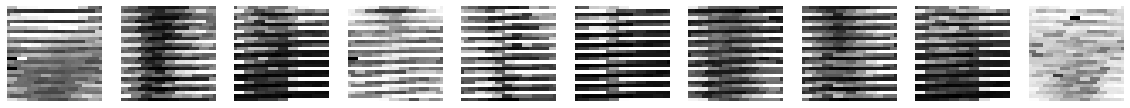

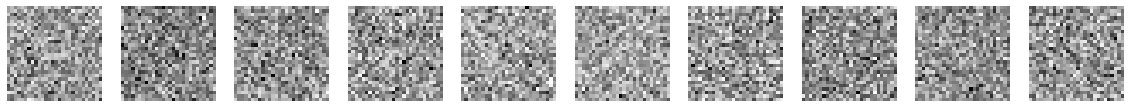

In [ ]:
# deciding how big we want our print out to be
rcParams['figure.figsize'] = 20,20
# looping through the first 10 test images and printing  them out
for i in range(10):
    plt.subplot(1, 10, i+1)
    plt.imshow(X_test[i].reshape(28,28),  cmap='Greys')
    plt.axis('off')
plt.show()
# printing out the noisy images
for i in range(10):
    plt.subplot(1, 10, i+1)
    plt.imshow(X_test_noisy[i].reshape(28,28),  cmap='Greys')
    plt.axis('off')
plt.show()

In [ ]:
# pick any image
any_image = X_test_noisy[10]
# run it though the autoencoder
output_any_image = sess.run(output_layer,
                   feed_dict={input_layer:[any_image]})